# Predict Austin, TX Water Consumption

The city of Austin has several public data sets detailing the monthly water consumption for different customer classes based on their zip code. These data span January 2012 to September 2018. 

### These are publicly available at:

Residential Data - https://data.austintexas.gov/Utilities-and-City-Services/Austin-Water-Residential-Water-Consumption/sxk7-7k6z

Commercial Data - https://data.austintexas.gov/Utilities-and-City-Services/Austin-Water-Commercial-Water-Consumption/5h9c-wmds

I will split this data into training and validation samples and use decision trees and random forests to predict the water consumption for different customer classes. 

### This has significant real-world applications
It is important for the city water utility to understand the demand from their customers, both commercial and residential, and how this consumption changes throughout the year. The ability to predict this demand in advance can optimize the city's use of resources. 

Additionally, in cases of clean water crisis, predictions of water demand can help better estimate the necessary emergency resources. A good understanding of the water requirements for the city would have proven useful during the [Austin clean water crisis of October 2018](https://www.texastribune.org/2018/10/22/austin-water-boil-water-notice-after-historic-flooding/). During this event, heavy rains and flooding introduced excessive silt into the Austin water treatment system. A "boil water notice" was implemented throughout the city. To combat this crisis, water was brought in from neighboring cities and water bottle handouts were set up throughout the city. This crisis severely impacted businesses throught the city and residential customers. 

In [1]:
## Imports for data processing and plotting
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
%matplotlib inline

## For implementing decision trees
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

## Plot settings
plt.rcParams['xtick.major.width'] = .9
plt.rcParams['xtick.major.size'] = 8.
plt.rcParams['xtick.minor.size'] = 5.
plt.rcParams['xtick.minor.width'] = .9
plt.rcParams['xtick.labelsize'] = 19.
plt.rcParams['ytick.major.width'] = .9
plt.rcParams['ytick.major.size'] = 8.
plt.rcParams['ytick.minor.size'] = 5.
plt.rcParams['ytick.minor.width'] = .9
plt.rcParams['ytick.labelsize'] = 19.
plt.rcParams['axes.linewidth'] = 2.
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelsize'] = 20.
matplotlib.rcParams['agg.path.chunksize'] = 10000
col1 = cm.viridis(np.linspace(0,0.8,13))
col2 = cm.Set2(np.linspace(0,1,8))
col3 = cm.Set3(np.linspace(0,1,12))

## Read in the data using Pandas

Then merge data sets for commercial and residential customers

In [2]:
indir = '/Users/sydney/Desktop/data_science/austinWater_decisionTree/data/'

### Residential data
residential_file = indir + 'Austin_Water_-_Residential_Water_Consumption.csv'
res_data = pd.read_csv(residential_file)

### Commercial data
commercial_file = indir + 'Austin_Water_-_Commercial_Water_Consumption.csv'
com_data = pd.read_csv(commercial_file)

In [3]:
## Concatenate the two tables to make one data frame
frames = [res_data, com_data]
all_data = pd.concat(frames, ignore_index=True)

## Make separate year and month columns
all_data['Year'] = all_data['Year Month'][:]//100
all_data['Month'] = all_data['Year Month'][:]%100

all_data.columns

Index(['Year Month', 'Postal Code', 'Customer Class', 'Total Gallons', 'Year',
       'Month'],
      dtype='object')

## Explore the data
Look at total consumption by month for 2012 - 2018

In [4]:
## Make arrays of the things we want to loop over to make the plot
cust_class_arr = np.unique(all_data['Customer Class'])
month_arr = np.unique(all_data['Month'])

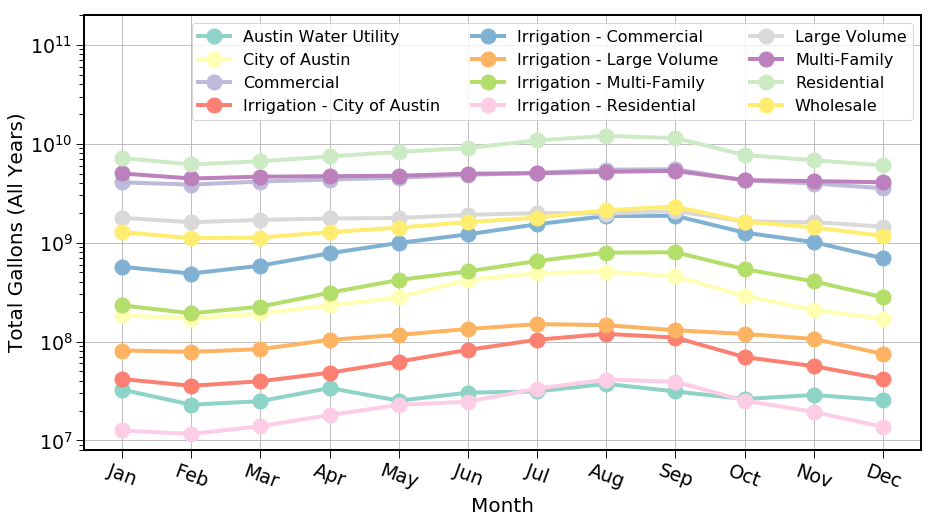

In [5]:
## Set up plot
fig=plt.figure(figsize=(15.0,8.0))
ax1=fig.add_subplot(111)
ax1.grid()

## Enter loop over months and customer class
color_num = 0
for cust in cust_class_arr:
    color_num += 1
    tot_gallons = np.zeros(len(month_arr))
    for month in month_arr:
        index = np.where((all_data['Month'][:] == month) & (all_data['Customer Class'][:] == cust))[0]
        tot_gallons[month-1] = np.sum(all_data['Total Gallons'][index])
        
    ax1.plot(month_arr, tot_gallons, 'o-', color=col3[color_num-1], markersize=15, linewidth=4)
        
plt.legend(cust_class_arr, ncol=3, fontsize=16)
        
month_strings = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(month_arr, month_strings, rotation=-20)

plt.yscale('log')
plt.ylim([8e6, 2e11])
plt.xlabel('Month')
plt.ylabel('Total Gallons (All Years)')

#### Notable trends:
- Peak water consumption occurs during the summer months when temperatures peak in Austin, TX
- Residential Class consumes the most water in the city
- Multi-family and commercial water consumption remains flat through the summer months when all other customer classes seem to peak in their consumption

## Build a decision tree model to predict monthly water consumption

In [6]:
## Replace Customer Class string with integers so that we can use it in the model
cust_class_arr = np.unique(all_data['Customer Class'])

## Make a new column to fill
all_data['CustClassInt'] = np.zeros(len(all_data['Month']))

## Loop through and fill the CustClassInt column
num = 0
for cust in cust_class_arr:
    num += 1
    index = np.where(all_data['Customer Class'][:] == cust)[0]
    all_data['CustClassInt'][index] = num

/Users/sydney/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [7]:
### Define prediction and features for the model

## Prediction
y = all_data['Total Gallons']

## Features
model_features = ['Postal Code', 'CustClassInt', 'Year', 'Month']
X = all_data[model_features]

In [8]:
### Split into a training and validation sample
train_X, val_X, train_y, val_y = train_test_split(X,y,random_state=1)

In [9]:
### Build the model
water_model = DecisionTreeRegressor(random_state = 1)

### Fit the model
water_model.fit(train_X, train_y)

### Make predictions
water_predict = water_model.predict(val_X)

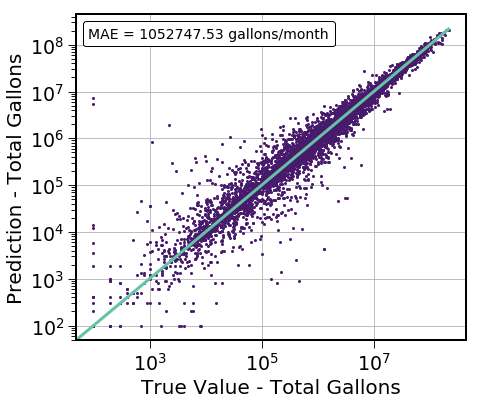

In [25]:
### Make plot of value recovery for the validation sample
fig=plt.figure(figsize=(7.0,6.0))
ax1=fig.add_subplot(111)
ax1.grid()

ax1.plot(val_y, water_predict, 'o', color=col1[1], markersize=2)

xmin = np.min(val_y)-500
xmax = np.max(val_y)+500
ymin = xmin
ymax = xmax
ax1.plot([xmin, xmax], [ymin, ymax], '-', color=col2[0], linewidth = 3)

mae = mean_absolute_error(val_y, water_predict)
at1 = AnchoredText('MAE = '+ str(np.around(mae,2)) + ' gallons/month', prop=dict(size=14), frameon=True,loc=2)
at1.patch.set_boxstyle('round',pad=0.,rounding_size=0.2)
ax1.add_artist(at1).set_zorder(16)

plt.yscale('log')
plt.xscale('log')
plt.xlabel('True Value - Total Gallons')
plt.ylabel('Prediction - Total Gallons')

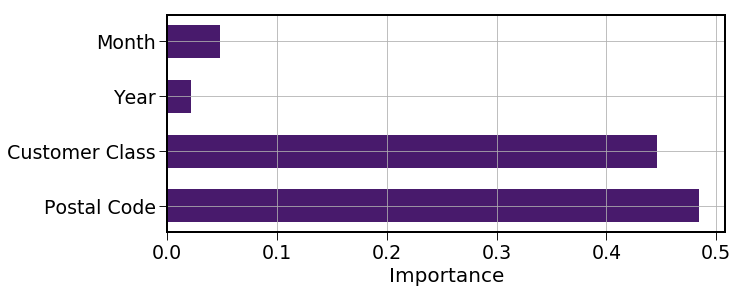

In [11]:
### How important were each of the features?
importance = water_model.feature_importances_

### Make a plot to show the results
fig=plt.figure(figsize=(10,4.0))
ax1=fig.add_subplot(111)
ax1.grid()

ax1.barh(np.arange(1,len(model_features)+1,1), importance, height=0.6, color=col1[1])

ylabels = ['Postal Code', 'Customer Class', 'Year', 'Month']
plt.yticks(np.arange(1,len(model_features)+1,1), ylabels)#, rotation=-20)

plt.xlabel('Importance')

## Decision tree model results
- Using a simple decision tree with four features, the model can predict the total water consumption from different customer classes each month in Austin, TX with a mean absolute error of 1,052,747.53 gallons.
- The most important features for this model are the postal code and customer class. Despite the seasonal trend of water consumption in the summer months, the month and year do not have significant importance in predicting water consumption

## Can this predictor be improved by using a random forest?

In [12]:
### Set up the model
forest_water_model = RandomForestRegressor(random_state=1)

## Fit the model
forest_water_model.fit(train_X, train_y)

## Make predictions
forest_water_prediction = forest_water_model.predict(val_X)

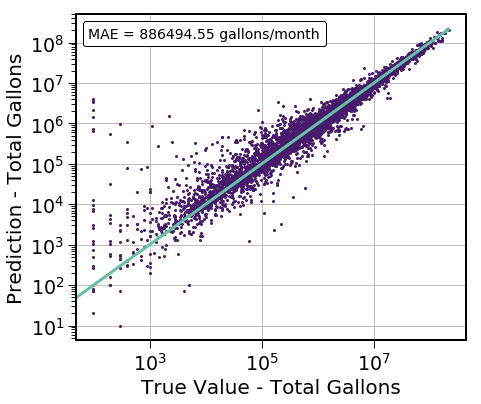

In [26]:
### Make plot of value recovery for the validation sample
fig=plt.figure(figsize=(7.0,6.0))
ax1=fig.add_subplot(111)
ax1.grid()

ax1.plot(val_y, forest_water_prediction, 'o', color=col1[1], markersize=2)

xmin = np.min(val_y)-500
xmax = np.max(val_y)+500
ymin = xmin
ymax = xmax
ax1.plot([xmin, xmax], [ymin, ymax], '-', color=col2[0], linewidth = 3)

mae = mean_absolute_error(val_y, forest_water_prediction)
at1 = AnchoredText('MAE = '+ str(np.around(mae,2)) + ' gallons/month', prop=dict(size=14), frameon=True,loc=2)
at1.patch.set_boxstyle('round',pad=0.,rounding_size=0.2)
ax1.add_artist(at1).set_zorder(16)

plt.yscale('log')
plt.xscale('log')
plt.xlabel('True Value - Total Gallons')
plt.ylabel('Prediction - Total Gallons')

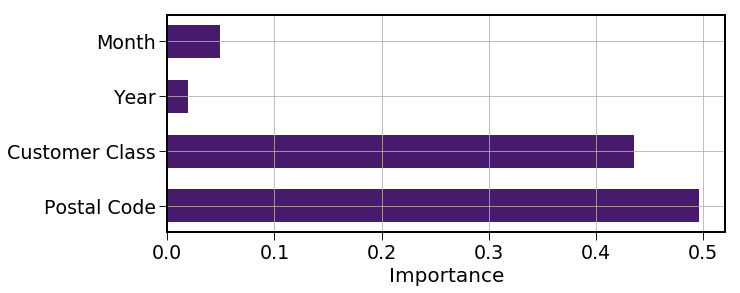

In [14]:
### How important were each of the features?
importance = forest_water_model.feature_importances_

### Make a plot to show the results
fig=plt.figure(figsize=(10,4.0))
ax1=fig.add_subplot(111)
ax1.grid()

ax1.barh(np.arange(1,len(model_features)+1,1), importance, height=0.6, color=col1[1])

ylabels = ['Postal Code', 'Customer Class', 'Year', 'Month']
plt.yticks(np.arange(1,len(model_features)+1,1), ylabels)#, rotation=-20)

plt.xlabel('Importance')

## Tree vs Forest
- Using a random forest improves the median absolute deviation by ~166,000 total gallons/month over a single decision tree
- In both cases, the most important feature is postal code, followed closely by customer class. The year and month have little influence
- When comparing the predicted values and the truth for the validation set, a single tree produced outliers that both over and under predicted the total number of gallons used. In the case of the random forest, the under-predictions were largely eliminated and the model is more likely to over-estimate the total gallons used. In terms of water consumption, it is better to over-estimate the nubmer of gallons needed than under-estimate. 

## Can this be improved further by adding a feature to the model? 
The city has additional data on the nubmer of service connections for each customer class in every postal code. The data can be found: https://data.austintexas.gov/Utilities-and-City-Services/Austin-Water-Water-Service-Connection-Count-By-Zip/uizf-mcbc

In [15]:
## Open the file and load in the data
connection_file = indir + 'Austin_Water_-_Water_Service_Connection_Count_By_Zip_Code.csv'
conn_data = pd.read_csv(connection_file)

## Merge this new dataframe with the residential & commercial data from before
new_all_data = pd.merge(all_data, conn_data,  how='left', left_on=['Postal Code','Customer Class'], right_on = ['Postal Code','Customer Class'])

## Some customer classes in different postal codes don't have any connections and these get placed as NaN in the table
# Fix this problem by changing NaN to zero
no_connection = np.isnan(new_all_data['Service Connections'])
fix_index = np.where(no_connection == True)[0]
new_all_data['Service Connections'][fix_index] = 0.0

/Users/sydney/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [16]:
### Define prediction and features for the model

## Prediction
y = new_all_data['Total Gallons']

## Features
model_features = ['Postal Code', 'CustClassInt', 'Year', 'Month', 'Service Connections']
X = new_all_data[model_features]

In [17]:
### Split into a training and validation sample
train_X, val_X, train_y, val_y = train_test_split(X,y,random_state=1)

## Decision Tree with new feature

In [18]:
### Build the model
water_model_new = DecisionTreeRegressor(random_state = 1)

### Fit the model
water_model_new.fit(train_X, train_y)

### Make predictions
water_predict_new = water_model_new.predict(val_X)

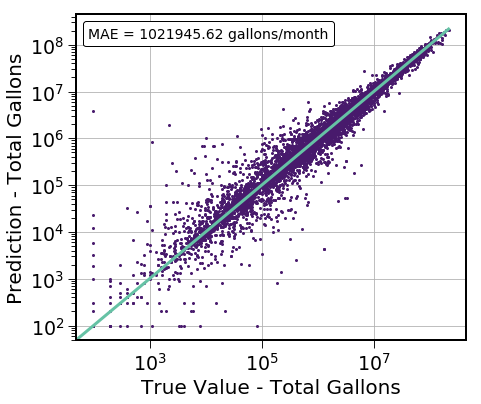

In [27]:
### Make plot of value recovery for the validation sample
fig=plt.figure(figsize=(7.0,6.0))
ax1=fig.add_subplot(111)
ax1.grid()

ax1.plot(val_y, water_predict_new, 'o', color=col1[1], markersize=2)

xmin = np.min(val_y)-500
xmax = np.max(val_y)+500
ymin = xmin
ymax = xmax
ax1.plot([xmin, xmax], [ymin, ymax], '-', color=col2[0], linewidth = 3)

mae = mean_absolute_error(val_y, water_predict_new)
at1 = AnchoredText('MAE = '+ str(np.around(mae,2)) + ' gallons/month', prop=dict(size=14), frameon=True,loc=2)
at1.patch.set_boxstyle('round',pad=0.,rounding_size=0.2)
ax1.add_artist(at1).set_zorder(16)

plt.yscale('log')
plt.xscale('log')
plt.xlabel('True Value - Total Gallons')
plt.ylabel('Prediction - Total Gallons')

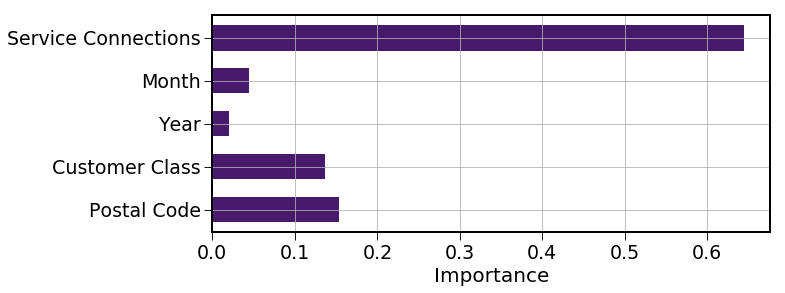

In [20]:
### How important were each of the features?
importance = water_model_new.feature_importances_

### Make a plot to show the results
fig=plt.figure(figsize=(10,4.0))
ax1=fig.add_subplot(111)
ax1.grid()

ax1.barh(np.arange(1,len(model_features)+1,1), importance, height=0.6, color=col1[1])

ylabels = ['Postal Code', 'Customer Class', 'Year', 'Month', 'Service Connections']
plt.yticks(np.arange(1,len(model_features)+1,1), ylabels)#, rotation=-20)

plt.xlabel('Importance')

## Result: tree with new feature
- The number of service connections is clearly an important feature and inclusion improves the MAE by ~31,000 total gallons/month over the original decision tree with only four features. 

## Random Forest with new feature

In [21]:
### Set up the model
forest_water_model_new = RandomForestRegressor(random_state=1)

## Fit the model
forest_water_model_new.fit(train_X, train_y)

## Make predictions
forest_water_prediction_new = forest_water_model_new.predict(val_X)

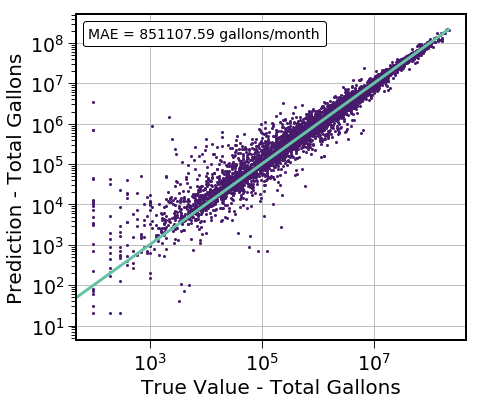

In [28]:
### Make plot of value recovery for the validation sample
fig=plt.figure(figsize=(7.0,6.0))
ax1=fig.add_subplot(111)
ax1.grid()

ax1.plot(val_y, forest_water_prediction_new, 'o', color=col1[1], markersize=2)

xmin = np.min(val_y)-500
xmax = np.max(val_y)+500
ymin = xmin
ymax = xmax
ax1.plot([xmin, xmax], [ymin, ymax], '-', color=col2[0], linewidth = 3)

mae = mean_absolute_error(val_y, forest_water_prediction_new)
at1 = AnchoredText('MAE = '+ str(np.around(mae,2)) + ' gallons/month', prop=dict(size=14), frameon=True,loc=2)
at1.patch.set_boxstyle('round',pad=0.,rounding_size=0.2)
ax1.add_artist(at1).set_zorder(16)

plt.yscale('log')
plt.xscale('log')
plt.xlabel('True Value - Total Gallons')
plt.ylabel('Prediction - Total Gallons')

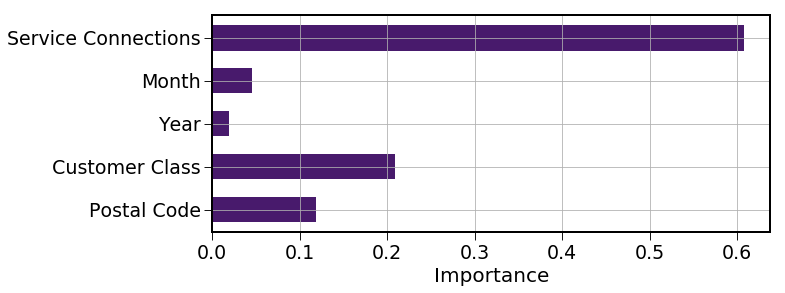

In [23]:
### How important were each of the features?
importance = forest_water_model_new.feature_importances_

### Make a plot to show the results
fig=plt.figure(figsize=(10,4.0))
ax1=fig.add_subplot(111)
ax1.grid()

ax1.barh(np.arange(1,len(model_features)+1,1), importance, height=0.6, color=col1[1])

ylabels = ['Postal Code', 'Customer Class', 'Year', 'Month', 'Service Connections']
plt.yticks(np.arange(1,len(model_features)+1,1), ylabels)#, rotation=-20)

plt.xlabel('Importance')

## Result: Forest with new feature
- Implementing a random forest with this new feature improved the MAE by ~171,000 total gallons/month over a single decision tree. 
- This addition also improved the MAE by ~35,000 gallons/month over the random forest that only used four features
- In the random forest, the number of service connections still has the greatest importance, but customer class emerges as a clear secondary feature in the fit, ranking higher than postal code. 

# Placing these results in context
Using a random forest predictor with five features (postal code, customer class, year, month, and number of service connections) this model is able to predict the total number of gallons required each month within a mean absolute error of 851,000 total gallons per month. While this seems like a large number, the city of Austin requires [~120 million gallons of water per day](https://www.texastribune.org/2018/10/22/austin-water-boil-water-notice-after-historic-flooding/), or ~3.6 billion gallons of water each month. Based on this consumption, an error of 851,000 total gallons per month is only 0.02% of the monthly water usage for the city. 

A simple random forest predictor does a remarkable job of predicting the water usage throughout the city. Not only would this model be helpful for optimizing water treatment in the city, but in the event of emergency it can help decide which water uses can be restricted to free up clean water for those in need, such as residential customers. 

## Further improving these predictions
This classifier would likely improve with an increased number of features to fit. For residential data, this may come in the form of number of residents and their age, or the square footage of the building. For commercial data, the building square footage and number of occupants would also be useful. Additionally, for irrigation-related water usage, data indicating the number of acres serviced by each irrigation class would also help to inform the model.  

The city of Austin has been rapidly growing over the previous decades. Although year does not seem to be a significant factor used in the model, the population of the city each year may also contribute to improved predicitons. 